## Imports

In [1]:
from pathlib import Path
import sys

# Add repo root and code/ to sys.path
repo_root = Path.cwd().parents[1]
sys.path.insert(0, str(repo_root))
sys.path.insert(0, str(repo_root / "code"))

from utils import helper_functions as hf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.registration import phase_cross_correlation
import os
import importlib
import torch
import torch.nn.functional as F
from scipy import signal
import cv2
from IPython import get_ipython
from IPython.display import display
import matplotlib
from matplotlib.colors import TwoSlopeNorm
from matplotlib.patches import Rectangle
from matplotlib import animation


---
### load subjects and plot raw fUS activity of their first session over time with label shading (blue = baseline)

Subject: secundo
  data_directory: C:\Users\ESPCI\Documents\GitHub\fUSPredict\sourcedata\secundo
  data_output_dir: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo
  - MISMATCH: Images=7500, Labels=8109. Shaving to 7500 frames.


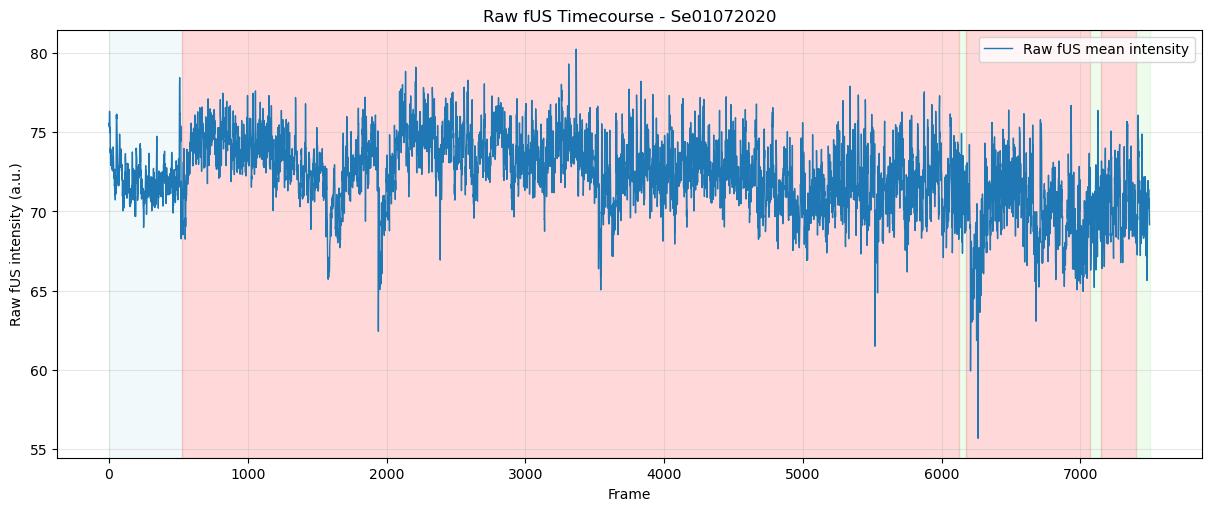

Subject: gus
  data_directory: C:\Users\ESPCI\Documents\GitHub\fUSPredict\sourcedata\gus
  data_output_dir: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus
  - MISMATCH: Images=8000, Labels=9198. Shaving to 8000 frames.


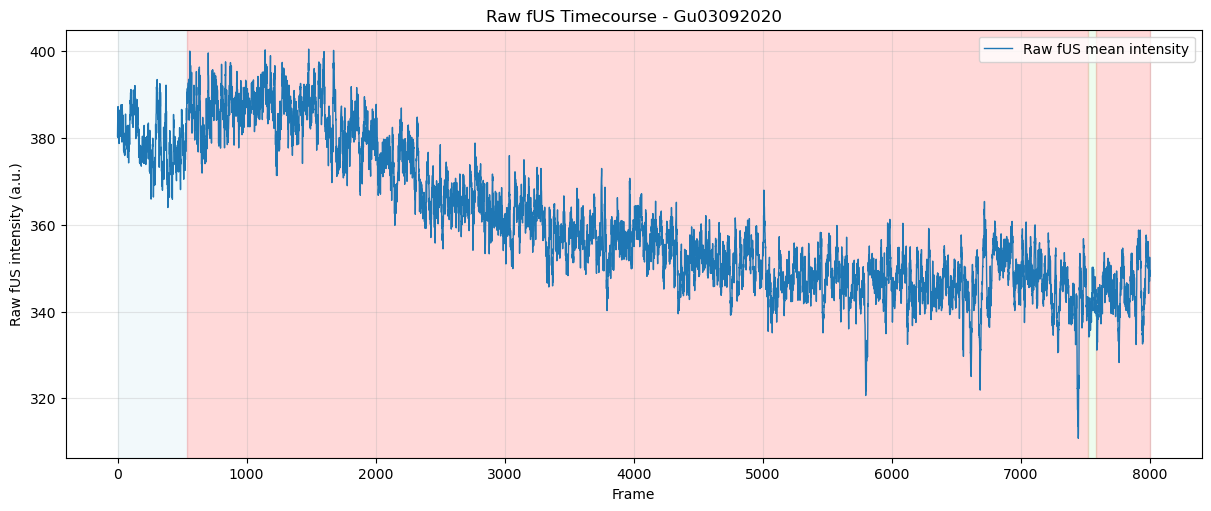

In [2]:
hf = importlib.reload(hf)

subjects = ["secundo", "gus"]

repo_root = Path(r"C:\Users\ESPCI\Documents\GitHub\fUSPredict")
source_root = repo_root / "sourcedata"
deriv_root = repo_root / "derivatives" / "preprocessing"

for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject  # subject-specific output folder
    data_output_dir.mkdir(parents=True, exist_ok=True)

    print(f"Subject: {subject}")
    print(f"  data_directory: {data_directory}")
    print(f"  data_output_dir: {data_output_dir}")

    hf.plot_fus_timecourse_with_labels(
        str(data_directory),
        sessions="first"
    )


---
### Extract and Save Baseline Frames

Extract baseline frames (blue shading above, label == -1) from all sessions and save as per-session .npz files.

In [ ]:

# Set up output directory for baseline files
for subject in subjects:
    fornorminnorm_mode in ["raw"mean_divide", "zscore"]:
    data_directory = source_root / subject/norm_mode
    data_output_dir = deriv_root / subject  # subject-specific output folder
    data_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = os.path.join(data_output_dir, "baseline_only")
    print(f"Baseline output directory: {baseline_output_dir}")

    # Process all files for that subject and save baseline files
    baseline_files = hf.process_all_baseline_files(data_directory, baseline_output_dir)

Baseline output directory: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\baseline_only
Found 34 fUS files to process

⏭️  Skipping Se01072020 (already exists)
⏭️  Skipping Se01092020 (already exists)
⏭️  Skipping Se01102020 (already exists)
⏭️  Skipping Se01122020 (already exists)
⏭️  Skipping Se02122020 (already exists)
⏭️  Skipping Se03022020 (already exists)
⏭️  Skipping Se03092020 (already exists)
⏭️  Skipping Se04022020 (already exists)
⏭️  Skipping Se04032020 (already exists)
⏭️  Skipping Se04062021 (already exists)
⏭️  Skipping Se04082020 (already exists)
⏭️  Skipping Se04092020 (already exists)
⏭️  Skipping Se05022020 (already exists)
⏭️  Skipping Se05082020 (already exists)
⏭️  Skipping Se06012020 (already exists)
⏭️  Skipping Se22092020 (already exists)
⏭️  Skipping Se22102019 (already exists)
⏭️  Skipping Se22112019 (already exists)
⏭️  Skipping Se23072020 (already exists)
⏭️  Skipping Se24022020 (already exists)
⏭️  Skipping Se24062020 (alread

---
### Load Baseline Data

Load baseline sessions for model training.

In [4]:
for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject  # subject-specific output folder
    data_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = os.path.join(data_output_dir, "baseline_only")
    # Load all baseline sessions
    baseline_sessions = hf.load_all_baseline(baseline_output_dir)

    # Print summary
    if len(baseline_sessions) > 0:
        print(f"\nBaseline Data Summary:")
        print(f"  Total sessions: {len(baseline_sessions)}")
        total_frames = sum(s['frames'].shape[0] for s in baseline_sessions)
        print(f"  Total baseline frames: {total_frames:,}")
        
        spatial_shapes = [s['frames'].shape[1:] for s in baseline_sessions]
        unique_shapes = set(spatial_shapes)
        print(f"  Spatial dimensions: {unique_shapes}")
        
        # Show frame count distribution
        frame_counts = [s['frames'].shape[0] for s in baseline_sessions]
        print(f"  Frames per session: min={min(frame_counts)}, max={max(frame_counts)}, "
            f"mean={np.mean(frame_counts):.0f}, std={np.std(frame_counts):.0f}")
        
        # first session
        if len(baseline_sessions) > 0:
            first_session = baseline_sessions[0]
            print(f"\n  First session ({first_session['session_id']}):")
            print(f"    Frames: {first_session['frames'].shape[0]}")
            print(f"    Shape: {first_session['frames'].shape}")
            print(f"    Dtype: {first_session['frames'].dtype}")
            print(f"    Value range: [{first_session['frames'].min():.2f}, {first_session['frames'].max():.2f}]")

✅ Loaded 34 baseline sessions

Baseline Data Summary:
  Total sessions: 34
  Total baseline frames: 14,043
  Spatial dimensions: {(128, 107), (128, 91), (128, 132), (128, 122), (128, 112), (128, 96), (128, 101)}
  Frames per session: min=1, max=906, mean=413, std=202

  First session (Se01072020):
    Frames: 526
    Shape: (526, 128, 101)
    Dtype: float32
    Value range: [9.31, 3374.84]
✅ Loaded 13 baseline sessions

Baseline Data Summary:
  Total sessions: 13
  Total baseline frames: 5,838
  Spatial dimensions: {(128, 81), (128, 132), (128, 122), (128, 112), (128, 96), (128, 101)}
  Frames per session: min=258, max=549, mean=449, std=123

  First session (Gu03092020):
    Frames: 539
    Shape: (539, 128, 112)
    Dtype: float32
    Value range: [9.11, 16195.08]


In [5]:
# for subject in subjects:
#     data_directory = source_root / subject
#     data_output_dir = deriv_root / subject
#     data_output_dir.mkdir(parents=True, exist_ok=True)
#     baseline_output_dir = data_output_dir / "baseline_only"

#     baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

#     if len(baseline_sessions) == 0:
#         print(f"No baseline sessions for {subject}")
#         continue

#     sample_session = baseline_sessions[0]
#     frame_idx = min(200, len(sample_session["frames"]) - 1)
#     sample_frame = sample_session["frames"][frame_idx]

#     plt.figure(figsize=(10, 6))
#     plt.imshow(np.log10(sample_frame.astype(np.float32) + 1e-8), cmap="viridis")
#     plt.colorbar(label="Intensity")
#     plt.title(f"{subject} | Session {sample_session['session_id']} | Frame {frame_idx}")
#     plt.xlabel("Width (pixels)")
#     plt.ylabel("Height (pixels)")
#     plt.tight_layout()
#     plt.show()


---

make one triplet video per subject (raw baseline, mean_divide normalized, zscore normalized)


In [6]:
# # export one triplet video per subject for a sample baseline acquisition:
# # [raw | mean_divide | zscore]
# # NOTE: normalization is unchanged; masking/smoothing below is display-only.

# fps = 10

# # display tuning (visualization only)
# mean_mask_percentile = 45.0   # keep brighter structural pixels
# std_mask_percentile = 45.0    # keep pixels with meaningful temporal variation
# signed_clip_percentile = 97.0 # tighter clipping than 99 to reduce speckle dominance
# gaussian_blur_ksize = 3        # 0/1 disables blur
# header_h = 28                  # top strip for labels


# def scale_raw_to_u8(frames, q_low=1.0, q_high=99.0):
#     """Positive-intensity visualization for raw frames."""
#     lo = np.percentile(frames, q_low)
#     hi = np.percentile(frames, q_high)
#     if hi <= lo:
#         lo = float(frames.min())
#         hi = float(frames.max())
#     scaled = (frames - lo) / (hi - lo + 1e-8)
#     return np.clip(scaled * 255.0, 0, 255).astype(np.uint8), lo, hi


# def scale_signed_to_u8(frames, abs_percentile=97.0):
#     """
#     Signed visualization for normalized frames.
#     127 ~= zero, darker negative, brighter positive.
#     """
#     a = np.percentile(np.abs(frames), abs_percentile)
#     if a <= 1e-8:
#         a = 1.0
#     clipped = np.clip(frames, -a, a)
#     scaled = ((clipped / a) + 1.0) * 127.5
#     return np.clip(scaled, 0, 255).astype(np.uint8), a


# def apply_optional_blur(gray_u8, ksize=3):
#     if ksize is None or ksize <= 1:
#         return gray_u8
#     return cv2.GaussianBlur(gray_u8, (ksize, ksize), 0)


# def add_header(panel_gray, text, header_height=28):
#     panel_bgr = cv2.cvtColor(panel_gray, cv2.COLOR_GRAY2BGR)
#     h, w = panel_bgr.shape[:2]
#     out = np.zeros((h + header_height, w, 3), dtype=np.uint8)
#     out[:header_height] = (0, 0, 0)
#     out[header_height:] = panel_bgr
#     cv2.putText(out, text, (8, int(header_height * 0.72)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
#     return out


# for subject in subjects:
#     data_output_dir = deriv_root / subject
#     data_output_dir.mkdir(parents=True, exist_ok=True)
#     baseline_output_dir = data_output_dir / "baseline_only"

#     baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

#     if len(baseline_sessions) == 0:
#         print(f"No baseline sessions for {subject}")
#         continue

#     # sample acquisition: first baseline session
#     sample_session = baseline_sessions[0]
#     sample_frames_raw = sample_session["frames"].astype(np.float32, copy=False)

#     # per-pixel temporal normalization on raw baseline frames
#     sample_frames_mean = hf.normalize_frames_pixelwise(sample_frames_raw, method="mean_divide")
#     sample_frames_z = hf.normalize_frames_pixelwise(sample_frames_raw, method="zscore")

#     # sanity checks (normalization math)
#     mean_map_raw = sample_frames_raw.mean(axis=0)
#     std_map_raw = sample_frames_raw.std(axis=0)

#     valid_mean = np.abs(mean_map_raw) > 1e-8
#     valid_std = std_map_raw > 1e-8

#     md_mean_abs_err = float(np.mean(np.abs(sample_frames_mean.mean(axis=0)[valid_mean]))) if np.any(valid_mean) else np.nan
#     zs_mean_abs_err = float(np.mean(np.abs(sample_frames_z.mean(axis=0)[valid_std]))) if np.any(valid_std) else np.nan
#     zs_std_abs_err = float(np.mean(np.abs(sample_frames_z.std(axis=0)[valid_std] - 1.0))) if np.any(valid_std) else np.nan

#     print(
#         f"{subject} sanity | mean_divide mean abs err={md_mean_abs_err:.6f}, "
#         f"zscore mean abs err={zs_mean_abs_err:.6f}, zscore std abs err={zs_std_abs_err:.6f}"
#     )

#     # display mask to suppress low-signal/background amplification (visualization only)
#     mean_thr = np.percentile(mean_map_raw, mean_mask_percentile)
#     std_thr = np.percentile(std_map_raw, std_mask_percentile)
#     display_mask = (mean_map_raw >= mean_thr) & (std_map_raw >= std_thr)

#     mean_display = sample_frames_mean.copy()
#     z_display = sample_frames_z.copy()
#     mean_display[:, ~display_mask] = 0.0
#     z_display[:, ~display_mask] = 0.0

#     raw_u8, raw_lo, raw_hi = scale_raw_to_u8(sample_frames_raw)
#     mean_u8, mean_abs = scale_signed_to_u8(mean_display, abs_percentile=signed_clip_percentile)
#     z_u8, z_abs = scale_signed_to_u8(z_display, abs_percentile=signed_clip_percentile)

#     n_frames = min(raw_u8.shape[0], mean_u8.shape[0], z_u8.shape[0])
#     h, w = raw_u8.shape[1], raw_u8.shape[2]

#     triplet_path = data_output_dir / f"{subject}_baseline_triplet_raw_mean_zscore.mp4"
#     fourcc = cv2.VideoWriter_fourcc(*"mp4v")
#     out = cv2.VideoWriter(str(triplet_path), fourcc, fps, (w * 3, h + header_h), isColor=True)

#     if not out.isOpened():
#         raise RuntimeError(f"Could not open video writer for {triplet_path}")

#     mask_pct = 100.0 * float(display_mask.mean())

#     for t in range(n_frames):
#         raw_panel = raw_u8[t]
#         mean_panel = apply_optional_blur(mean_u8[t], ksize=gaussian_blur_ksize)
#         z_panel = apply_optional_blur(z_u8[t], ksize=gaussian_blur_ksize)

#         raw_lbl = f"raw [{raw_lo:.2f},{raw_hi:.2f}]"
#         mean_lbl = f"mean_divide +/-{mean_abs:.3f}"
#         z_lbl = f"zscore +/-{z_abs:.3f}"

#         raw_bgr = add_header(raw_panel, raw_lbl, header_height=header_h)
#         mean_bgr = add_header(mean_panel, mean_lbl, header_height=header_h)
#         z_bgr = add_header(z_panel, z_lbl, header_height=header_h)

#         panel = np.concatenate([raw_bgr, mean_bgr, z_bgr], axis=1)
#         out.write(panel)

#     out.release()
#     print(
#         f"Saved triplet video for {subject} | session={sample_session['session_id']} | "
#         f"frames={n_frames} | display_mask={mask_pct:.1f}% -> {triplet_path}"
#     )


normalize baseline-only sessions (raw frames) using pixel-wise temporal normalization

Modes:
- mean_divide: (x - mean_t) / mean_t per pixel
- zscore:      (x - mean_t) / std_t per pixel


In [7]:
# normalize baseline-only sessions per pixel over time and save both modes

norm_modes = ['mean_divide', 'zscore']

for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject
    data_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = data_output_dir / 'baseline_only'

    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

    if len(baseline_sessions) == 0:
        print(f'No baseline sessions for {subject}')
        continue

    normalized_root = data_output_dir / 'baseline_only_normalized'
    normalized_root.mkdir(parents=True, exist_ok=True)

    print(f'\nSubject: {subject}')
    print(f'  Sessions: {len(baseline_sessions)}')

    for mode in norm_modes:
        mode_dir = normalized_root / mode
        mode_dir.mkdir(parents=True, exist_ok=True)

        for sess in baseline_sessions:
            frames = sess['frames']  # (T, H, W), raw baseline frames only
            session_id = sess['session_id']

            norm_frames = hf.normalize_frames_pixelwise(frames, method=mode)

            out_path = mode_dir / f'baseline_{session_id}_{mode}.npz'
            np.savez_compressed(
                out_path,
                frames=norm_frames,
                session_id=session_id,
                normalization=mode,
                source='raw_baseline_only'
            )

        sample = hf.normalize_frames_pixelwise(baseline_sessions[0]['frames'], method=mode)
        print(
            f"  - {mode}: saved {len(baseline_sessions)} sessions | "
            f"sample range=[{sample.min():.4f}, {sample.max():.4f}]"
        )


✅ Loaded 34 baseline sessions

Subject: secundo
  Sessions: 34
  - mean_divide: saved 34 sessions | sample range=[-0.8361, 3.0000]
  - zscore: saved 34 sessions | sample range=[-3.0000, 3.0000]
✅ Loaded 13 baseline sessions

Subject: gus
  Sessions: 13
  - mean_divide: saved 13 sessions | sample range=[-0.8743, 3.0000]
  - zscore: saved 13 sessions | sample range=[-3.0000, 3.0000]
